# 0. Import, data read, function definition

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error

In [3]:
!ls data

sample_submission.csv  submission1.csv	submission_rff.csv
submission0.csv        submission2.csv	test.csv
submission100.csv      submission3.csv	train.csv


In [4]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

print(train.columns)

Index(['id', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14',
       'target'],
      dtype='object')


In [5]:
X_test = test.iloc[:,1:]
X_train = train.iloc[:,1:-1]
Y_train = train.iloc[:,-1]

# get id, useful for kaggle subsmission
test_id = test.id
train_id = train.id

print(X_test.shape, X_train.shape, Y_train.shape) 
# our input space has 14 dimensions
# with 200 000 test examples, and 300 000 train examples
# output space has 1 dimension

(200000, 14) (300000, 14) (300000,)


In [6]:
def kernelize(X,kernel="linear"):
    """
    inputs:
        apply linear kernel to our data
        X : pandas dataframe, containing dimensions in columns
    returns :
        X_new : dataframe resulting of the application of the kernel on X dataframe
    """
    new_X = []
    X_columns = X.columns
    N_columns = len(X.columns)
    new_columns = []
    if kernel =="linear" or kernel=="exponential":
        for i in range(N_columns):
            for j in range(N_columns):
                if i <= j : # since our kernel is symetric, we may compute only half of the operations
                    col0, col1 = X_columns[i], X_columns[j]
                    new_columns.append("k(" + col0 + "," + col1 + ")")
                    if kernel == "linear":
                        new_X.append(copy.deepcopy(np.multiply(X[col0], X[col1])))
                    if kernel == "exponential":
                        new_X.append(copy.deepcopy(np.exp(X[col0] + X[col1])))


    new_X = pd.concat(new_X, axis=1)
    new_X.columns = new_columns
    return new_X

In [7]:
def make_kaggle_submission(Y, id_list, file_name = "submission.csv"):
    """
    convert Y array into the correct format for kaggle submission
    & save into csv file 
    & returns the submission
    """
    df = pd.DataFrame(Y, index=id_list, columns = ["target"])
    
    df.to_csv("data/" + file_name)
    
    return df

# 1. MKL

## 1.1. Kernel method with a chosen kernel

In [8]:
# We apply product kernel

X_test_linear_kernel = kernelize(X_test)
X_train_linear_kernel = kernelize(X_train)

print(X_train_linear_kernel.shape, X_test_linear_kernel.shape) # we get a 105 dimension space

(300000, 105) (200000, 105)


## 1.2. Ridge regression in the feature space

In [9]:
regressor = Ridge()

In [10]:
regressor.fit(X_train_linear_kernel.values, Y_train)

Ridge()

In [11]:
Y_predict = regressor.predict(X_test_linear_kernel)

In [12]:
print("predicted variance :", Y_predict.var(),"\ntraining variance :", Y_train.var())
print("\npredicted mean :", Y_predict.mean(),"\ntraining mean :", Y_train.mean())
print("\npredicted min :", Y_predict.min(),"\ntraining min :", Y_train.min())
print("\npredicted max :", Y_predict.max(),"\ntraining max :", Y_train.max())

predicted variance : 0.018928769204603988 
training variance : 0.5373928423339634

predicted mean : 7.905108132030333 
training mean : 7.905661328316826

predicted min : 7.085882010461103 
training min : 0.0

predicted max : 8.830757355454708 
training max : 10.267568500800396


In [13]:
# The classifier predict values that are in a shorter interval comparing to what we get in the training set
# It would be interesting to search why
# It may be a problem if test and train sets are constructed by random sampling per example

In [14]:
make_kaggle_submission(Y_predict, id_list=test_id, file_name="submission0.csv")

# Result of this submission (RMSE = 0.72255)

,target
id,
0,8.019208
2,7.778296
6,7.938228
7,7.940062
10,8.212541
...,...
499984,8.057480
499985,7.950218
499987,7.823627


## 1.3. Multiple Kernel Learning implementation (MKL)

In [15]:
# compute exponential kernelization
X_test_exponential_kernel = kernelize(X_test, kernel="exponential")
X_train_exponential_kernel = kernelize(X_train, kernel="exponential")

In [16]:
# we compare the results of ridge regression with regularization on the custom kernel ( linear kernel + beta * exponential kernel)
beta_values = [0.01,0.05,0.1,0.5,2,5]
score_mean = []
score_variance = []
for beta in beta_values:
# We split our kernelized arrays into a test and training set

    X = X_train_linear_kernel + beta * X_train_exponential_kernel
    scores = []
    for i in range(5):
        x_train, x_test, y_train, y_test = train_test_split(X, Y_train)
    
        regressor = Ridge()
    
        regressor.fit(x_train, y_train)
    
        y_predict = regressor.predict(x_test)
        
        scores.append(mean_squared_error(y_predict, y_test)) # compute score of prediction
        
    score_mean.append(np.mean(scores))
    score_variance.append(np.var(scores)) # get mean and variance of the score for a givent beta value (multiple runs by selecting different test/train set)

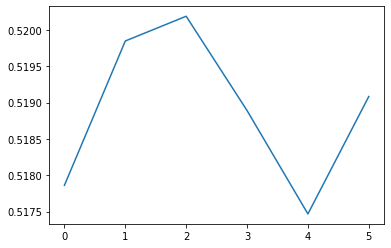

In [17]:
plt.plot(score_mean)

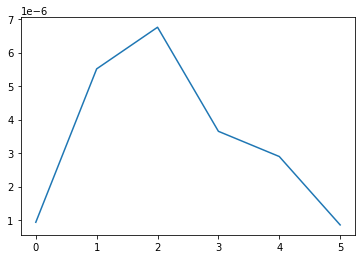

In [18]:
plt.plot(score_variance)

In [19]:
# make prediction for best model : beta = 0.05 (this model has the lowest RMSE)
 
beta=0.05

X_train_custom_kernel = X_train_linear_kernel + beta * X_train_exponential_kernel
X_test_custom_kernel = X_test_linear_kernel + beta * X_test_exponential_kernel

regressor = Ridge()
    
regressor.fit(X_train_custom_kernel, Y_train)

Y_predict = regressor.predict(X_test_custom_kernel)

make_kaggle_submission(Y_predict, id_list=test_id, file_name="submission1.csv") # submission score : 0.72252, not much better than simple linear kernel

,target
id,
0,8.019017
2,7.776441
6,7.935983
7,7.937434
10,8.211425
...,...
499984,8.058539
499985,7.952694
499987,7.822385


In [20]:
# make prediction for best model : beta = 2 (this model has the lowest variance, which means it should generalize well)
 
beta=2

X_train_custom_kernel = X_train_linear_kernel + beta * X_train_exponential_kernel
X_test_custom_kernel = X_test_linear_kernel + beta * X_test_exponential_kernel

regressor = Ridge()
    
regressor.fit(X_train_custom_kernel, Y_train)

Y_predict = regressor.predict(X_test_custom_kernel)

make_kaggle_submission(Y_predict, id_list=test_id, file_name="submission2.csv") # submission score :0.72243, not much better than simple linear kernel

,target
id,
0,8.018698
2,7.773477
6,7.924713
7,7.924599
10,8.204401
...,...
499984,8.064910
499985,7.969698
499987,7.817245


In [21]:
# make prediction for exponential kernel alone


regressor = Ridge()
    
regressor.fit(X_train_exponential_kernel, Y_train)

Y_predict = regressor.predict(X_test_exponential_kernel)

make_kaggle_submission(Y_predict, id_list=test_id, file_name="submission3.csv") # submission score :0.72243, not much better than simple linear kernel


,target
id,
0,8.018570
2,7.774312
6,7.922536
7,7.922427
10,8.202680
...,...
499984,8.066081
499985,7.973160
499987,7.816666


# 2. Approximation de noyau

## 2.1 Random Fourier Features

In [8]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_random_state

In [9]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

print(train.columns)

Index(['id', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14',
       'target'],
      dtype='object')


In [10]:
X_test = test.iloc[:,1:]
X_train = train.iloc[:,1:-1]
Y_train = train.iloc[:,-1]

# get id, useful for kaggle subsmission
test_id = test.id
train_id = train.id

print(X_test.shape, X_train.shape, Y_train.shape) 
# our input space has 14 dimensions
# with 200 000 test examples, and 300 000 train examples
# output space has 1 dimension

(200000, 14) (300000, 14) (300000,)


In [11]:
def rand_four_feat(X, nb_feat=100, random_state=None):
    """
    Renvoie le vecteur X, transformé grâce aux Random Fourier Features
    
    :X: np.array, the dataset to extract fourier_features from.
    :nb_feat: int, number of features to be computed.
    :random_state: int, seed to be fed if you want your experiment to be reproducible.
    
    :output: np.array(), the dataset X transformed into the Fourier space.
    """
    W = check_random_state(random_state).randn(X.shape[1], nb_feat) # create random feature map
    
    phi = np.hstack([np.cos(X@W), np.sin(X@W)])

    return phi

In [12]:
phi_100_train = rand_four_feat(X_train, random_state=1970)
phi_100_test = rand_four_feat(X_test, random_state=1970)

In [12]:
regressor = Ridge()

In [13]:
regressor.fit(phi_100_train, Y_train)

Ridge()

In [14]:
Y_predict = regressor.predict(phi_100_test)

In [15]:
print("predicted variance :", Y_predict.var(),"\ntraining variance :", Y_train.var())
print("\npredicted mean :", Y_predict.mean(),"\ntraining mean :", Y_train.mean())
print("\npredicted min :", Y_predict.min(),"\ntraining min :", Y_train.min())
print("\npredicted max :", Y_predict.max(),"\ntraining max :", Y_train.max())

predicted variance : 0.022292363934234657 
training variance : 0.5373928423339634

predicted mean : 7.905247018099854 
training mean : 7.905661328316826

predicted min : 7.30556617962605 
training min : 0.0

predicted max : 8.773881051269674 
training max : 10.267568500800396


In [16]:
# The classifier predict values that are in a shorter interval comparing to what we get in the training set
# It would be interesting to search why
# It may be a problem if test and train sets are constructed by random sampling per example

In [17]:
make_kaggle_submission(Y_predict, id_list=test_id, file_name="submission_rff.csv")

# Result of this submission (RMSE = 0.71995)

,target
id,
0,8.113152
2,7.828764
6,8.028194
7,7.971309
10,8.274574
...,...
499984,8.033176
499985,7.957762
499987,7.857433


## 2.2 Nystrom Kernel Ridge

In [19]:
def nyst_kern_ridg(X, y, random_state=None, m=None):
    """
    On est obligés de travailler sur 10% du dataset d'entraînement, sinon on ne peut pas
    stocker en mémoire les matrices de travail.
    """
    rand_idx = np.array(range(X.shape[0]))
    check_random_state(random_state).shuffle(rand_idx)
    rand_idx = rand_idx[:25000]
    
    X_val = X.values[rand_idx]
    y_val = y.values[rand_idx]
    
    if m:
        assert self.m <= X_val.shape[0] # check if the new number of features is lower than before
    m = m or int(np.sqrt(X_val.shape[0])) # if not defined take the square root of the initial number of samples

    # take random samples 
    rng = check_random_state(random_state).choice(X_val.shape[0], m, replace=False)
    landmarks = X_val[rng, :]
    
    # compute approximate kernel
    C = X_val @ landmarks.T
    
    W = C[rng, :]
    pinv_W = np.linalg.pinv(W)
    
    # Save values now for prediction
    alpha = (np.eye(len(C)) - C @ np.linalg.pinv(W + C.T @ C) @ C.T) @ y_val
    
    return alpha, C, pinv_W, landmarks

def nyst_pred_ridg(X, alpha, C, pinv_W, landmarks):
    """
    """
    y_pred = []
    
    delmt = X.shape[0]//10
    
    for k in range(10):
        X_val = X.values[k*delmt:(k+1)*delmt]

        new_C = X_val @ landmarks.T
        K = new_C @ pinv_W @ C.T    
    
        y_pred.append(K @ alpha)
        
    return np.concatenate(y_pred)

In [17]:
alpha, C, pinv_W, landmarks = nyst_kern_ridg(X_train, Y_train, random_state=1970)

In [21]:
Y_predict = nyst_pred_ridg(X_test, alpha, C, pinv_W, landmarks)

In [22]:
print("predicted variance :", Y_predict.var(),"\ntraining variance :", Y_train.var())
print("\npredicted mean :", Y_predict.mean(),"\ntraining mean :", Y_train.mean())
print("\npredicted min :", Y_predict.min(),"\ntraining min :", Y_train.min())
print("\npredicted max :", Y_predict.max(),"\ntraining max :", Y_train.max())

predicted variance : 1.2865518712159527 
training variance : 0.5373928423339634

predicted mean : 7.735768503904243 
training mean : 7.905661328316826

predicted min : 3.224709935739753 
training min : 0.0

predicted max : 12.930977446144425 
training max : 10.267568500800396


In [23]:
# The classifier predict values that are in a shorter interval comparing to what we get in the training set
# It would be interesting to search why
# It may be a problem if test and train sets are constructed by random sampling per example

In [25]:
make_kaggle_submission(Y_predict, id_list=test_id, file_name="submission_nys.csv")

# Result of this submission (RMSE = 1.33150)

,target
id,
0,6.500832
2,7.880824
6,7.563675
7,6.277436
10,7.404784
...,...
499984,8.298287
499985,6.207350
499987,6.490376


In [ ]:
# Best performances of prediction (RMSE) are obtained with the Nystrom approximation.
# It is probably more adapted to the studied scenario beacuse we take less dimensions than naive use of kernels
# It lowers our biais, so we get better generalization performances